# Project 3 | Classification of Skin Lesions
### Classifying skin lesions using scipy, sklearn and cv2

This notebook contains a step by step process to recreate the results of the report.

A detailed explination of regarding feature extraction and choices of classification model can be found in the report.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import path
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import cv2
from sklearn.preprocessing import StandardScaler
import groupXY_functions as util

# Feature extraction

- load segmenation mask and lesion image
- extract features
- write to csv file

In [2]:
#reading groundtruth for the full 2000 pictures 
df = pd.read_csv(path.ground_truth)

In [3]:
for index, line in df.iterrows():
	
	# for each image in ground truth, load img, mask
	id_ = line['image_id'] 
	
	img = cv2.imread(path.images+f'{id_}.jpg')
	mask = cv2.imread(path.segmentation+f'{id_}_segmentation.png',0)

	img, mask = util.scale_image_res(img,mask)
	
	img_plt, mask_plt = plt.imread(path.images+f'{id_}.jpg'), plt.imread(path.segmentation+f'{id_}_segmentation.png')
	img_plt, mask_plt = util.scale_image_res(img_plt,mask_plt)	
 
	# remove skin from lesion pictures.
	res = cv2.bitwise_and(img,img,mask = mask)
	notmask = cv2.bitwise_not(mask)
	notres = cv2.bitwise_and(img,img,mask = notmask)
	
	# get bounding box
	a,b,c,d = util.extract_bboxes(np.array(mask))
	print(index)


	# add feature to df
	df.at[index, ['color_lesion_r','color_lesion_g','color_lesion_b']] = util.averageColorsSimple(res)

	df.at[index, ['color_skin_r','color_skin_g','color_skin_b']] = util.averageColorsSimple(notres)

	df.at[index, ['area','perimeter']] = util.measure_area_perimeter(mask)

	df.at[index, ['min_symmetry', 'avg_symmetry']] = util.all_deg(mask[a:b,c:d])

	# df.at[index, ['border_dark', 'border_skin']] = util.boundry_check2(img_plt,mask_plt)

	df.at[index, ['color_variance']] = util.color_variance(img_plt, mask_plt)

0
1
2
3
4
5
6
7
8
9
10
11


KeyboardInterrupt: 

In [7]:
df = pd.read_csv(path.out+'out_rescaled.csv', index_col=0)
df.drop(['seborrheic_keratosis'], axis=1, inplace=True)
df.set_index('image_id', inplace = True)
df

,melanoma,color_lesion_r,color_lesion_g,color_lesion_b,color_skin_r,color_skin_g,color_skin_b,area,perimeter,min_symmetry,avg_symmetry,color_variance
image_id,,,,,,,,,,,,
ISIC_0000000,0.0,39.054190,36.538438,40.255583,131.778399,112.052640,91.833945,93199950.0,92836720.0,16029.0,7.049952e+04,151.360497
ISIC_0000001,0.0,2.845744,3.609158,5.347413,162.981837,158.673963,161.133578,13683300.0,13630556.0,2767.0,4.245661e+03,80.006250
ISIC_0000002,1.0,33.629795,32.640172,39.234969,154.099134,118.378237,97.091812,60678015.0,60442135.0,12255.0,2.758868e+04,111.763142
ISIC_0000003,0.0,23.266308,31.746686,44.736262,145.226959,144.897696,145.935318,66636855.0,66377384.0,15177.0,2.240491e+04,133.195345
ISIC_0000004,1.0,52.905618,43.803538,64.394117,27.534957,25.022511,26.508849,68880345.0,68611974.0,5921.0,3.635539e+04,137.091211
...,...,...,...,...,...,...,...,...,...,...,...,...
ISIC_0015220,0.0,35.906329,43.317209,102.319993,31.248853,32.884912,56.015390,146078280.0,145508436.0,146078280.0,1.460783e+08,77.162167
ISIC_0015233,0.0,15.658445,20.133662,29.912802,90.463575,110.652808,163.966020,49971585.0,49777107.0,13782.0,2.372966e+04,143.687160
ISIC_0015260,0.0,6.732133,10.198769,16.232717,133.427841,148.020522,169.899677,40330800.0,40174553.0,11523.0,3.770876e+04,130.847239


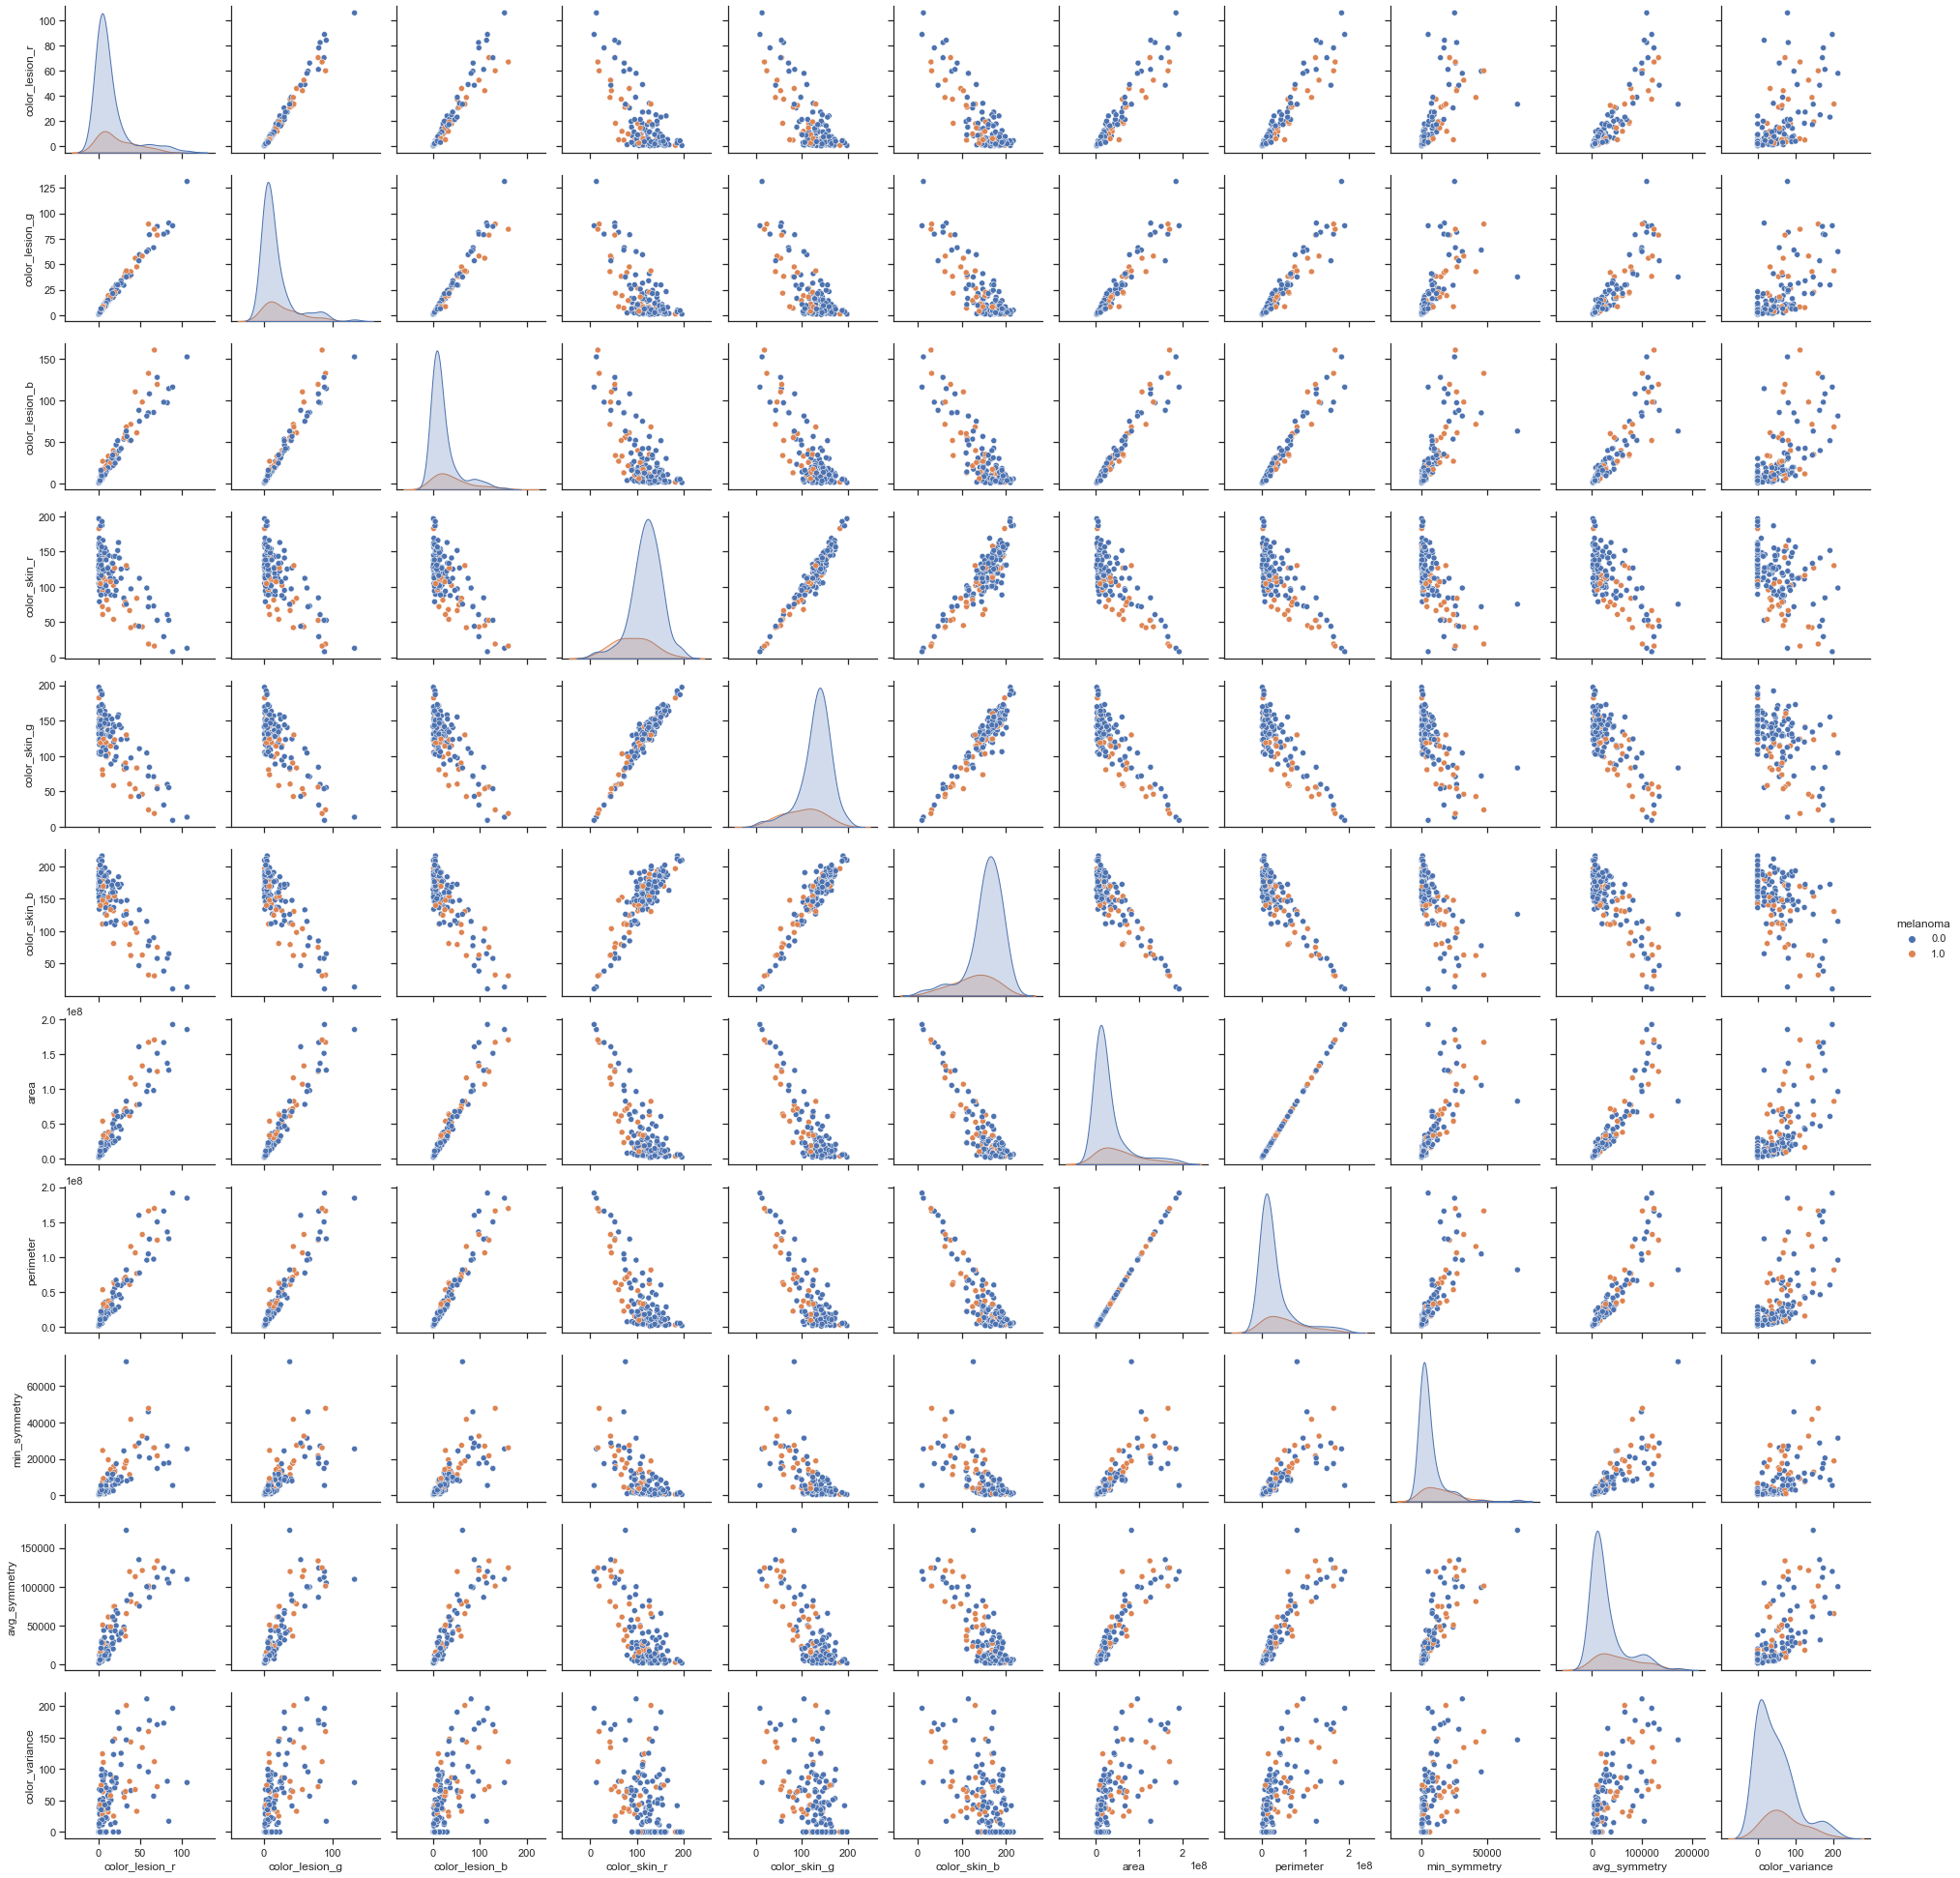

In [9]:
colors = {0:'tab:blue', 1:'tab:red'}
sns.pairplot(df, hue='melanoma')

## Note
Looking at perimiter compaired to area in the pairplot we see that its very correlated, the larger pictures will have more pixels sticking out. This compelled us to devide perimeter by area

In [8]:
df['std_perimiter'] = df['perimeter']/df['area']

To capture some of the irregularities in the border we added the formula for circularity

In [9]:
df['circularity'] = (4*np.pi*df['area'])/(df['perimeter'])**2

Scaled with standard scalar

In [10]:
#scaling features with standardscalar
featureDf = df.drop(['melanoma'], axis=1,)
#logfeature = np.log(featureDf)

scalar = StandardScaler().fit(featureDf)

In [11]:
scaled_features = scalar.transform(featureDf)

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(scaled_features)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'],index=logfeature.index)

In [12]:
#combining scaled df with our Y values
scaled_features_df = pd.DataFrame(scaled_features, index=featureDf.index, columns=featureDf.columns)
finalDf = pd.concat([scaled_features_df, df[['melanoma']]], axis = 1)

In [24]:
from sklearn.model_selection import train_test_split

df2=finalDf
# Some noisy features

# Add the noisy data to the informative features
X = df2.drop(['melanoma'], axis=1,)
#X = df2[['area','perimeter']] 
y = df2['melanoma']

# Split dataset to select feature and evaluate the classifier
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y, random_state=180)

X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev, random_state=180)


In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


# Train a classifier
# Split dataset to select feature and evaluate the classifier
lst = []
for i in range(1,10):
    innerlst = []
    for j in range(1,1000):
        X_dev, X_test, y_dev, y_test = train_test_split(
                X, y, stratify=y, random_state=j)

        X_train, X_val, y_train, y_val = train_test_split(
                X_dev, y_dev, stratify=y_dev, random_state=j)


        knn = KNeighborsClassifier(n_neighbors=i) # other hyperparameters possible
        knntrained = knn.fit(X_train, y_train)

        dtree = DecisionTreeClassifier()
        #dtree = dtree.fit(X_train, y_train)

        #y_val_tree = dtree.predict(X_val)
        y_val_knn = knntrained.predict(X_val)

        acc_knn = accuracy_score(y_val, y_val_knn)
        #acc_tree = accuracy_score(y_val, y_val_tree)

        auc_knn = roc_auc_score(y_val, y_val_knn)
        #auc_tree = roc_auc_score(y_val, y_val_tree)

        innerlst.append(auc_knn)
    lst.append(np.mean(innerlst))


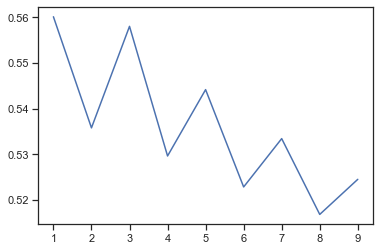

In [54]:
plt.plot(range(1,10),lst)


In [40]:
# ONLY FOR REPORTING, also evaluate on test set
X_test = X_test

y_test_knn = knntrained.predict(X_test)

auc_test = roc_auc_score(y_test, y_test_knn)

print(auc_test)

# For small datasets these results will depend on the random seed you chose when splitting, 
# this is why it is good to look at multiple splits/cross-validation

0.5916666666666667


In [41]:
import pickle
with open('pickle_knn.pickle','wb') as pickle_out:
    pickle.dump(knntrained,pickle_out)

with open('pickle_scalar.pickle','wb') as scalar_out:
    pickle.dump(scalar,scalar_out)

In [27]:
with open('pickel_knn.pickle','rb') as pickle_out:
     knn_loaded = pickle.load(pickle_out)

In [44]:
X_test = X_test

y_test_knn = knn_loaded.predict(X_test)

auc_test = roc_auc_score(y_test, y_test_knn)

print(auc_test)

0.6083333333333333
